In [6]:
import pydyna
import inhousedp
import math
import math
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import pandas as pd

In [7]:
my_dyna = pydyna.create_simulation("Maersk Handler.p3d")
my_dyna.reset()
my_vessel = my_dyna.vessels['42']
my_thrusters = list(my_vessel.thrusters)
my_vessel.linear_position = [0.0, 0.0, -6.6]
my_vessel.angular_position = [0.0, 0.0, 0.0]
print(my_vessel.linear_position)
print(my_vessel.angular_position)
print(my_thrusters)
my_dp = inhousedp.InhouseDP("/home/lhscaldas/Documentos/TCC/Outros/inHouseDP/Maersk Handler.p3d", 42)

[ 0.   0.  -6.6]
[0. 0. 0.]
['0', '1', '14', '4', '5']


In [17]:
my_dyna.reset()
serie_t_2 = []
serie_x_2 = []
serie_y_2 = []
serie_yaw_2 = []
my_dp.setgains(inhousedp.Dof.SURGE.value, 5.0, 0.1, 900.0)
my_dp.setreference([10.0, 0.0, 0.0])

[ 7.9473225  -0.4036404  -6.93043034]
[ 0.46255431  0.00149415 -0.61679724]


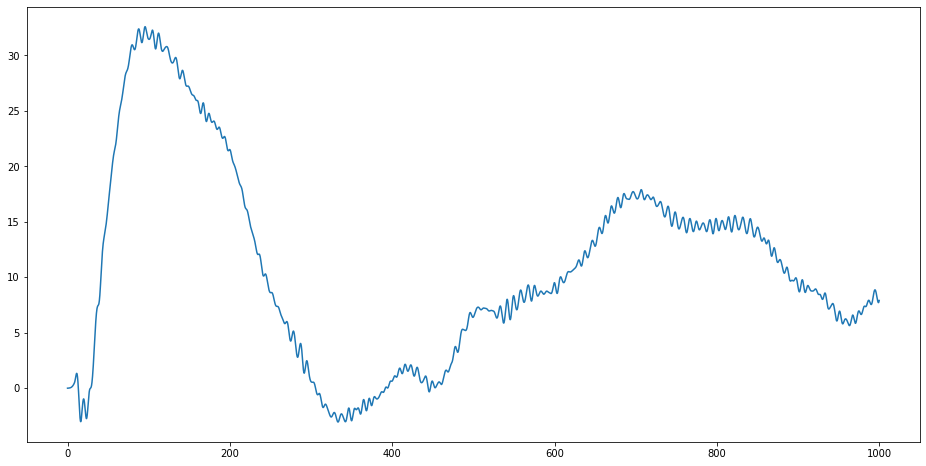

In [18]:
for cycle in range(10000):
    serie_t_2.append(my_dyna.get_time_step() * my_dyna.get_dt())
    serie_x_2.append(my_vessel.linear_position[0])
    serie_y_2.append(my_vessel.linear_position[1])
    serie_yaw_2.append(my_vessel.angular_position[2])

    my_var = my_dp.dostep([
        my_vessel.linear_position[0],
        my_vessel.linear_position[1],
        my_vessel.angular_position[2]
    ])
    for one_thr in my_thrusters:
        my_vessel.thrusters[one_thr].dem_rotation = my_var[one_thr].getDemandedRps()
        my_vessel.thrusters[one_thr].dem_pitch = my_var[one_thr].getDemandedPod()
        my_vessel.thrusters[one_thr].dem_angle = my_var[one_thr].getDemandedAzimuth()
    
    my_dyna.step()

print(my_vessel.linear_position)
print(my_vessel.linear_velocity)
plt.plot(serie_t_2,serie_x_2)
plt.show()

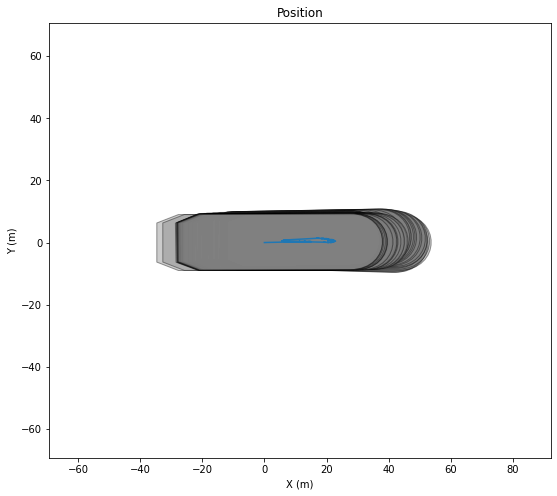

In [10]:
plt.rcParams["figure.figsize"] = (16,8)
data = pd.DataFrame({'t': serie_t_2, 'px': serie_x_2, 'py': serie_y_2, 'yaw': serie_yaw_2})
fig, (ax1) = plt.subplots(1, 1)
ax1.set_aspect('equal')

Path = mpath.Path
path_data = [
    (Path.MOVETO, [0.0, -0.5]),
    (Path.LINETO, [-0.35, -0.5]),
    (Path.LINETO, [-0.5, -0.4]),
    (Path.LINETO, [-0.5, -0.35]),
    (Path.LINETO, [-0.5, 0.3]),
    (Path.CURVE4, [-0.5, 0.5]),
    (Path.CURVE4, [0.5, 0.5]),
    (Path.LINETO, [0.5, 0.3]),
    (Path.LINETO, [0.5, 0.3]),
    (Path.LINETO, [0.5, -0.35]),
    (Path.LINETO, [0.5, -0.4]),
    (Path.LINETO, [0.35, -0.5]),
    (Path.CLOSEPOLY, [0.0, -0.5])
]

codes, verts = zip(*path_data)
ship = [[x[0] * my_vessel.breadth, x[1] * my_vessel.length] for x in verts]

for key, t in enumerate(data['t']):
    if (key % 100) == 0:
        alpha = data['yaw'][key] - math.pi/2
        item = [[x[0] * math.cos(alpha) - x[1] * math.sin(alpha), 
            x[0] * math.sin(alpha) + x[1] * math.cos(alpha)] for x in ship]
        item = [[x[0] + data['px'][key], x[1] + data['py'][key]] for x in item]

        path = mpath.Path(item, codes)
        patch = mpatches.PathPatch(path, facecolor='gray', alpha=0.4)
        ax1.add_patch(patch)

ax1.plot(data['px'], data['py'])

ax1.set_title("Position")
ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")

ax1.set_ylim(data['py'].min() - my_vessel.length, data['py'].max() + my_vessel.length)
ax1.set_xlim(data['px'].min() - my_vessel.length, data['px'].max() + my_vessel.length)

plt.show()